In [1]:
from sklearn.datasets import make_blobs 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_decision_regions
import time
import numpy as np

### Generate the database

In [2]:
inputs, target = make_blobs(n_samples=1000, random_state=365, centers=[(-3,3), (0,0), (2,2)])


* input contains x and y coordinates of the data points
* target is a one dimentional array that holds the labels of each data point

In [33]:
inputs.shape, target.shape

((1000, 2), (1000,))

In [34]:
data = pd.DataFrame(data=inputs, columns=["Feature 1", "Feature 2"])

In [35]:
data['Target'] = target

### Plot the database

In [36]:
sns.set()

In [37]:
knn_palette = sns.color_palette(['#000C1F', '#29757A', '#FF5050', '#ff7f00'])
knn_palette

[(0.0, 0.047058823529411764, 0.12156862745098039),
 (0.1607843137254902, 0.4588235294117647, 0.47843137254901963),
 (1.0, 0.3137254901960784, 0.3137254901960784)]

<AxesSubplot:xlabel='Feature 1', ylabel='Feature 2'>

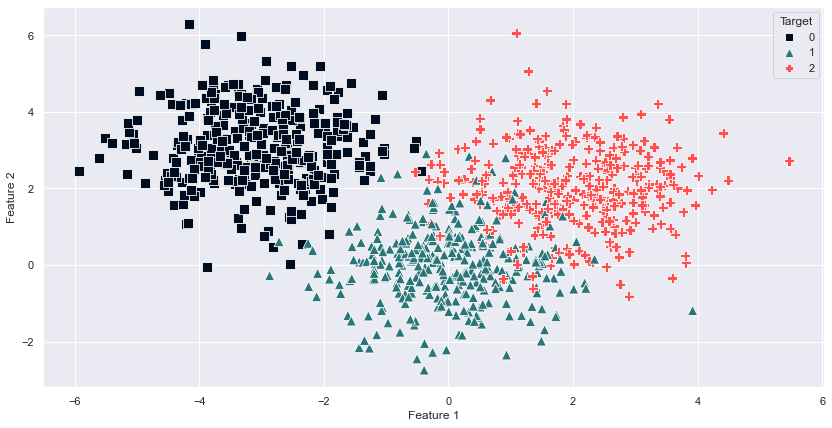

In [38]:
plt.figure(figsize=(14,7))
sns.scatterplot(data=data, 
                x='Feature 1', 
                y='Feature 2', 
                hue='Target',
                palette=knn_palette, 
                markers=[',', '^', 'P'], 
                style='Target', 
                s=100)

### Random dataset: classification

#### Create train-test-split to avoid overfitting

In [41]:
x_train, x_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2, random_state=365, stratify=target)
# stratify allows equal split of classes enterred the trainning and testing

#### Creating the model

In [82]:
clf = KNeighborsClassifier(n_neighbors=30, weights='uniform')
clf.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=30)

#### Predicting a sample

In [63]:
feature1 = -0.18
feature2 = 3.2

In [64]:
clf.predict([(feature1, feature2)])

array([2])

Retrieve the coordinates of the nearest neighbors

In [65]:
neighbors = clf.kneighbors([(feature1, feature2)])
neighbors

(array([[0.27086818, 0.34749744]]), array([[336, 215]], dtype=int64))

* the first array stores the euclidean distance from point O to its nearest neighbor
* the second stores the index of the neighbor in the trainning dataset

#### Visualizing the neighbors

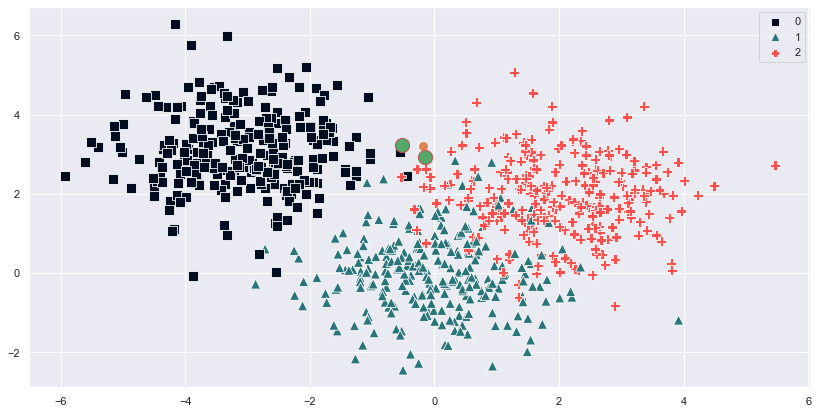

In [66]:
plt.figure(figsize=(14,7))

sns.scatterplot(x=x_train[:, 0], 
                y=x_train[:, 1], 
                hue=y_train,
                palette=knn_palette,
                markers=[",", "^", "P"], 
                style=y_train,
                s=100)

sns.scatterplot(x=[feature1], 
                y=[feature2],
                markers=['o'], 
                style=[feature2],
                s=100,
                legend=False)


plot_x_train = []
plot_y_train = []

for i in neighbors[1]:
    plot_x_train.append(x_train[i,0])
    plot_y_train.append(x_train[i,1])
    
plt.scatter(plot_x_train, plot_y_train, s=200, facecolors=None, edgecolors='r')

#### Getting the parameters of the model

In [67]:
clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 2,
 'p': 2,
 'weights': 'distance'}

weight: uniform
* equally classify point O to  square and plus

there is a competition between the two classes: class 0 (square) and class 2 (plus). Using mode (the most common), but in this case, only one point for each class, using the one has the smallest index to return

=> thus need to change the parameter of the classifier to use "distance" for weight (weight=1/distance). Shorter distance => higher weight

Review what we did:
* Give the algorithm a set of coordinates and let it determine the class bases on its neighbors

#### Draw decision regions

What we aim to do is comparing the decision region of only few neighbors and with many neighbors

Time elapses 17.1 seconds


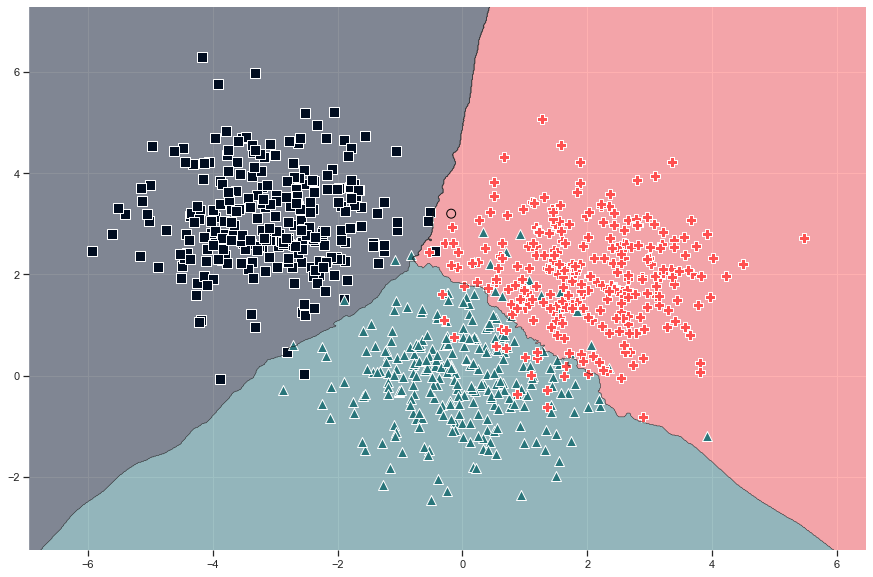

In [83]:
start = time.time()
plt.figure(figsize=(15,10))
plot_decision_regions(X=x_train, 
                      y=y_train,
                      X_highlight=np.array([(feature1, feature2)]), 
                      clf=clf,
                     markers=[',', '^', 'P'],
                     colors='#000C1F,#29757A,#FF5050',
                     scatter_kwargs={'s': 100, 'edgecolor':'white', 'alpha':1},
                     legend=0)
end = time.time()
print(f'Time elapses {round(end-start, 1)} seconds')


k=1 here is not a good choice
* create decision boundary unique to each trainning set
* introduce a single new data point will introduce a huge change in the decision boundary
* Likely overfit during trainning
* Perform poorly on testing set\
=> low bias, high variance

k=30:
* the decision boundary is smoothed out, not affected by background noise or outlier  \
* tendency to misclassify \
* underfitting
=> high bias, low varinace 

#### Determine the K-value

* Measure the number of misclassified data points as K increases
* Error rate = 1-accuracy

#### Getting the error rate of a set of models

In [88]:
error_uniform = [] # error rates from models with uniform distributed weights
error_distance = [] # error rates from models determined by weight equals to the inverse of distance

k_range = range(1,51)

for k in k_range:
    clf = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    clf.fit(x_train, y_train)
    predictions = clf.predict(x_test)
    error_uniform.append(1-accuracy_score(y_test, predictions))
    
    clf = KNeighborsClassifier(n_neighbors=k, weights='distance')
    clf.fit(x_train, y_train)
    predictions = clf.predict(x_test)
    error_distance.append(1-accuracy_score(y_test, predictions))

#### Plot the error rates as a function of the number of neighbors 

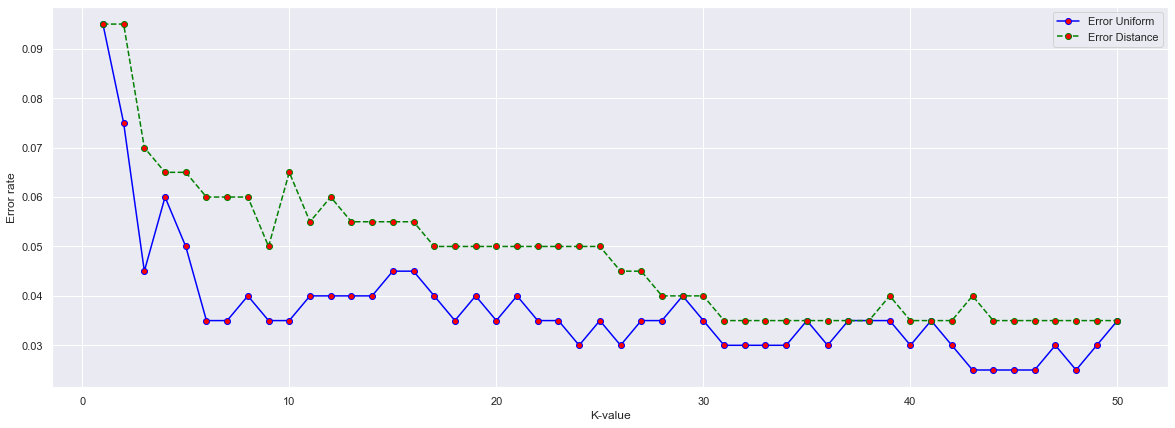

In [96]:
plt.figure(figsize=(20,7))
plt.plot(k_range, error_uniform, c='blue', linestyle="solid", marker='o', markerfacecolor='red', label='Error Uniform')
plt.plot(k_range, error_distance, c='green', linestyle="dashed", marker='o', markerfacecolor='red', label='Error Distance')
plt.legend()
plt.xlabel('K-value')
plt.ylabel('Error rate')
plt.show()

Choose one that has the error rate that is not very low to avoid high variance and not very big to avoid high bias

### Grid Search

GridSearch helps test all models using cross-validation\
Cross validation where the trainning data is split into trainning and validation set.
* trainning set is used for trainning
* validation set is used to fine tune the hyperparameters


#### Choose a set of parameters

In [98]:
parameters = {'n_neighbors': range(1,51), 'weights': ['uniform', 'distance']}

#### Create an instance of GridSearchCV

In [100]:
grid_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=parameters, scoring='accuracy')

In [101]:
grid_search.fit(x_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 51),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

* Create model for each combination of parameters and fit the trainning set

In [102]:
grid_search.best_params_

{'n_neighbors': 10, 'weights': 'uniform'}

In [103]:
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=10)

In [104]:
clf = grid_search.best_estimator_

In [105]:
grid_search.best_score_

0.9512499999999999

Best score: is the mean of all accuracies obtained from cross validation

### Make predictions based on the test dataset

In [107]:
y_test_pred = clf.predict(x_test)

In [108]:
y_test_pred.shape

(200,)

### Construct a confusion matrix

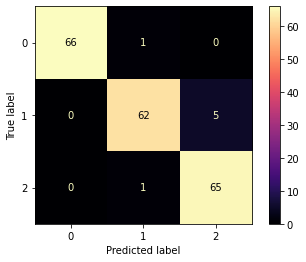

In [113]:
sns.reset_orig()
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, labels=clf.classes_, cmap='magma')

#### Print the classfication report

In [114]:
print(classification_report(y_test, y_test_pred, target_names=['0', '1', '2']))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        67
           1       0.97      0.93      0.95        67
           2       0.93      0.98      0.96        66

    accuracy                           0.96       200
   macro avg       0.97      0.97      0.96       200
weighted avg       0.97      0.96      0.97       200



* Precision = TP / (TP + FP) (true positive divides by all predicted as positive)
* Recall = TP / (TP + FN) (true positive divides by all samples that are indeed positive)
* f1-score = 2/(1/precision + 1/recall)

### KNN

Good when:
* cannot classify using single line
* cannot assume the function of data \
=> algorithm operates based on majority voting on the k nearest neighbors, rather than rely on the type of function => non parametric algorithm

Cons:
* Cannot predict based on the true form of data
* Extrapolation is not to be trusted
* Use KNN for low dimensional problem, more dimention requires more data
* Not suitable for categorical data